In [1]:
!pip install gymnasium

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# Initialize the CartPole environment
env = gym.make('CartPole-v1')

In [3]:
# Hyperparameters
alpha = 0.1       # learning rate
gamma = 0.99      # discount factor
epsilon = 0.1     # exploration rate
episodes = 750    # number of episodes to run

### Q-Learning

In [4]:
def epsilon_greedy_policy(Q, state, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()  # Explore: random action
    else:
        return np.argmax(Q[state])  # Exploit: best action based on current Q-values

In [5]:
def q_learning(env, episodes, alpha=0.1, gamma=0.99, epsilon=0.1, num_bins=10):
    """Q-learning algorithm implementation for continuous state space.

    Args:
        env: The environment to run the algorithm on.
        episodes: The number of episodes to run.
        alpha: The learning rate.
        gamma: The discount factor.
        epsilon: The exploration rate.
        num_bins: The number of bins to discretize each state dimension.

    Returns:
        Q: The learned Q-table.
        rewards: A list of rewards obtained in each episode.
    """

    # Discretize the continuous state space
    bins = [
        np.linspace(env.observation_space.low[i], env.observation_space.high[i], num_bins - 1)
        for i in range(env.observation_space.shape[0])
    ]

    def discretize_state(state):
        """Discretizes a continuous state into a discrete index."""
        return tuple(np.digitize(state[i], bins[i]) for i in range(len(state)))

    # Initialize Q-table randomly
    Q = {}  # Use a dictionary to store Q-values for discrete states

    rewards = []

    for episode in range(episodes):
        total_reward = 0
        state = env.reset()[0]  # Get the initial state
        discrete_state = discretize_state(state)  # Discretize the state
        done = False

        while not done:
            if discrete_state not in Q:
                Q[discrete_state] = np.zeros(env.action_space.n)  # Initialize if not present

            action = epsilon_greedy_policy(Q, discrete_state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            discrete_next_state = discretize_state(next_state)

            if discrete_next_state not in Q:
                Q[discrete_next_state] = np.zeros(env.action_space.n)  # Initialize if not present

            best_next_action = np.argmax(Q[discrete_next_state])
            td_target = reward + gamma * Q[discrete_next_state][best_next_action] * (1 - done)
            td_error = td_target - Q[discrete_state][action]
            Q[discrete_state][action] += alpha * td_error
            discrete_state = discrete_next_state
            total_reward += reward

        rewards.append(total_reward)
        if episode % 100 == 0:
            print(f"Episode {episode}: Total Reward = {total_reward}")

    return Q, rewards

/usr/local/lib/python3.11/dist-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.11/dist-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start


Episode 0: Total Reward = 9.0
Episode 100: Total Reward = 8.0
Episode 200: Total Reward = 33.0
Episode 300: Total Reward = 12.0
Episode 400: Total Reward = 58.0
Episode 500: Total Reward = 20.0
Episode 600: Total Reward = 23.0
Episode 700: Total Reward = 34.0


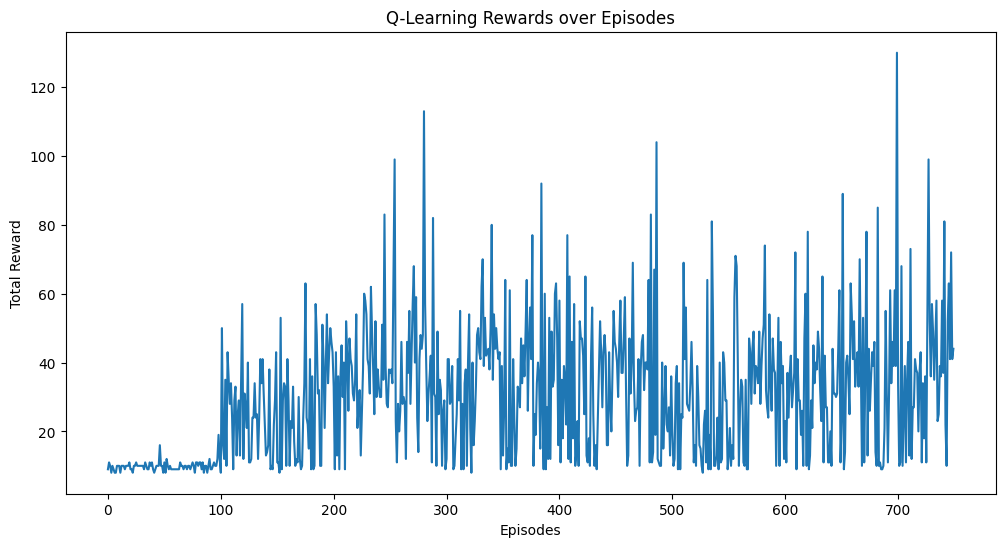

In [6]:
# Number of episodes to run
episodes = 750

# Running the Q-learning algorithm
Q, rewards = q_learning(env, episodes)

# Plotting the rewards to see how the agent learns over time
plt.figure(figsize=(12, 6))
plt.plot(rewards)
plt.title('Q-Learning Rewards over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

### TD(0)

In [7]:
def epsilon_greedy_policy(state, V, epsilon=0.1):
    """Choose an action based on epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Random action
    else:
        # Assuming optimal policy as random for demonstration
        return env.action_space.sample()

In [8]:
def td_zero(env, episodes, alpha=0.1, gamma=0.99, num_bins=10):
    """TD(0) algorithm for estimating V under a given policy."""

    # Discretize the continuous state space
    bins = [
        np.linspace(env.observation_space.low[i], env.observation_space.high[i], num_bins - 1)
        for i in range(env.observation_space.shape[0])
    ]

    def discretize_state(state):
        """Discretizes a continuous state into a discrete index."""
        return tuple(np.digitize(state[i], bins[i]) for i in range(len(state)))

    # Initialize value function for discretized states
    V = {}  # Use a dictionary to store values for discrete states

    for episode in range(episodes):
        state = env.reset()[0]  # Reset environment and get initial state
        discrete_state = discretize_state(state)
        done = False
        while not done:
            action = epsilon_greedy_policy(state, V)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            discrete_next_state = discretize_state(next_state)

            # Initialize V for unseen states
            if discrete_state not in V:
                V[discrete_state] = 0.0
            if discrete_next_state not in V:
                V[discrete_next_state] = 0.0

            # TD(0) update rule for discretized states
            V[discrete_state] += alpha * (reward + gamma * V[discrete_next_state] - V[discrete_state])

            discrete_state = discrete_next_state  # Update state for the next step
            state = next_state # Update the continuous state

    return V

In [9]:
# Number of episodes to run
episodes = 750

# Run TD(0)
value_function = td_zero(env, episodes)

# Print the learned value function (for demonstration)
print("Learned Value Function:")
for state, value in value_function.items():
    print(f"State: {state}, Value: {value}")

Learned Value Function:
State: (5, 9, 4, 9), Value: 15.691483793577753
State: (5, 9, 5, 9), Value: 20.650786704000456
State: (5, 9, 3, 9), Value: 5.338686396678661
State: (5, 9, 2, 9), Value: 0.0
State: (4, 9, 4, 9), Value: 19.588459530295417
State: (4, 9, 5, 9), Value: 17.224094553862788
State: (4, 9, 6, 9), Value: 6.323342110970761
State: (4, 9, 7, 9), Value: 0.0
State: (5, 9, 6, 9), Value: 12.88347700860655
State: (5, 9, 7, 9), Value: 0.0
State: (4, 9, 3, 9), Value: 11.601831960673895
State: (4, 9, 2, 9), Value: 0.0


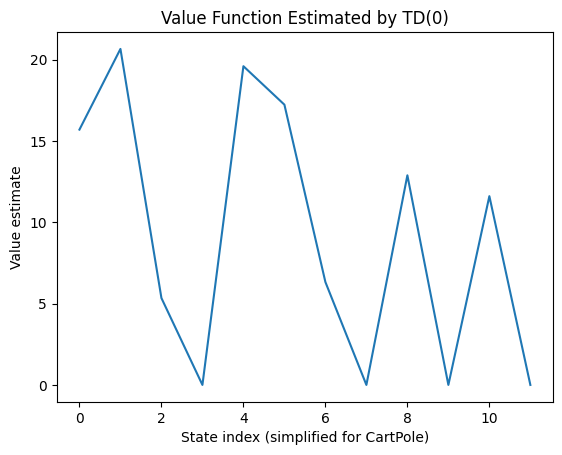

In [10]:
plt.plot(list(value_function.values()))
plt.title('Value Function Estimated by TD(0)')
plt.xlabel('State index (simplified for CartPole)')
plt.ylabel('Value estimate')
plt.show()

### SARSA

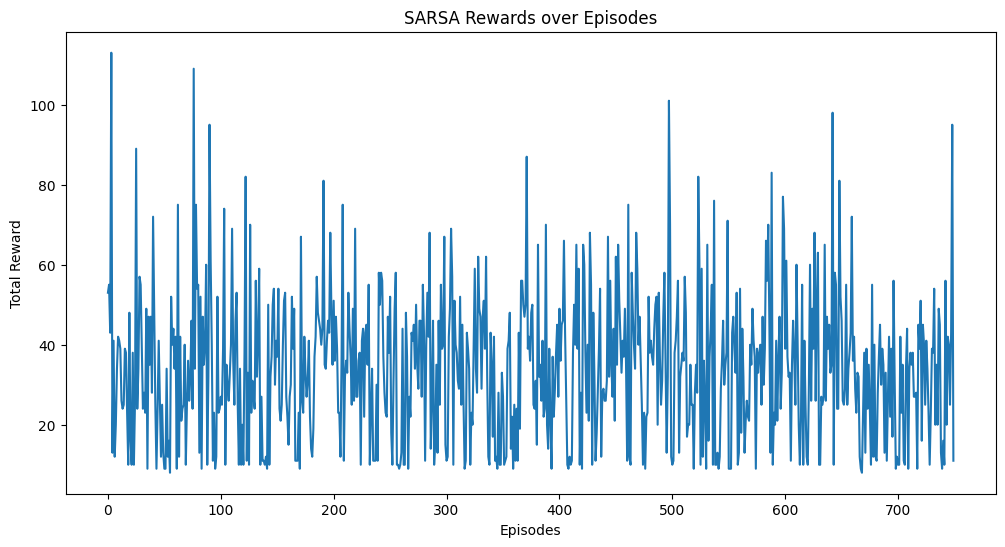

In [11]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

def epsilon_greedy_policy(state, Q, epsilon=0.1):
    """Choose an action based on epsilon-greedy policy."""
    # Convert the state to a hashable representation
    state_tuple = tuple(state)
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Random action
    else:
        # If state not in Q, initialize with zeros
        if state_tuple not in Q:
            Q[state_tuple] = np.zeros(env.action_space.n)
        return np.argmax(Q[state_tuple])  # Exploit: choose best action

def sarsa(env, Q, episodes, alpha, gamma, epsilon, num_bins=10):
    """SARSA algorithm for estimating Q."""
    rewards = []  # List to store total rewards per episode

    # Discretize the continuous state space (similar to q_learning)
    bins = [
        np.linspace(env.observation_space.low[i], env.observation_space.high[i], num_bins - 1)
        for i in range(env.observation_space.shape[0])
    ]

    def discretize_state(state):
        """Discretizes a continuous state into a discrete index."""
        return tuple(np.digitize(state[i], bins[i]) for i in range(len(state)))

    for episode in range(episodes):
        state = env.reset()[0]  # Reset the environment for a new episode, and get initial state
        # Discretize the state
        discrete_state = discretize_state(state)
        action = epsilon_greedy_policy(discrete_state, Q, epsilon)  # Initial action
        total_reward = 0  # Initialize total reward for the episode

        done = False
        while not done:
            # Take a step in the environment, handling the new return signature
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated # Episode is done if terminated or truncated
            total_reward += reward  # Accumulate reward

            # Discretize the next state
            discrete_next_state = discretize_state(next_state)
            next_action = epsilon_greedy_policy(discrete_next_state, Q, epsilon)  # Next action from next state

            # If state not in Q, initialize with zeros
            if discrete_state not in Q:
                Q[discrete_state] = np.zeros(env.action_space.n)

            # SARSA update formula
            Q[discrete_state][action] = Q[discrete_state][action] + alpha * (reward + gamma * Q[discrete_next_state][next_action] - Q[discrete_state][action]) if discrete_next_state in Q else Q[discrete_state][action] + alpha * (reward - Q[discrete_state][action])

            # Update state and action
            discrete_state = discrete_next_state
            action = next_action

        rewards.append(total_reward)  # Append total reward for this episode

    return Q, rewards

# Assuming env, episodes, alpha, gamma, epsilon are defined
# Run SARSA and collect rewards
Q, rewards = sarsa(env, Q, episodes, alpha, gamma, epsilon)

# Plotting the rewards
plt.figure(figsize=(12, 6))
plt.plot(rewards)
plt.title('SARSA Rewards over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

### DQN

In [14]:
import gymnasium as gym
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import matplotlib.pyplot as plt

# Set up the environment
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Parameters for DQN
gamma = 0.95  # discount rate
epsilon = 1.0  # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.001
batch_size = 64
memory_size = 1000  # Reduced memory size to lower memory usage
num_episodes = 1000
update_freq = 10  # Frequency of model training

# Deep Q-Network (DQN) model
def build_model():
    model = Sequential()
    model.add(Dense(24, input_dim=state_size, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

# Replay memory to store experiences
memory = deque(maxlen=memory_size)

# Function to choose actions using epsilon-greedy policy
def choose_action(state, model):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    else:
        q_values = model.predict(state, verbose=0)
        return np.argmax(q_values[0])

# Function to store experience in replay memory
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

# Function to replay and train the model
def replay(model, batch_size):
    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    states = np.array([x[0][0] for x in minibatch])  # Get the actual state (shape (4,))
    actions = np.array([x[1] for x in minibatch])
    rewards = np.array([x[2] for x in minibatch])
    next_states = np.array([x[3][0] for x in minibatch])  # Get the actual next state
    dones = np.array([x[4] for x in minibatch])
    # if len(memory) < batch_size:
    #     return
    # minibatch = random.sample(memory, batch_size)
    # states = np.array([x[0] for x in minibatch])
    # actions = np.array([x[1] for x in minibatch])
    # rewards = np.array([x[2] for x in minibatch])
    # next_states = np.array([x[3] for x in minibatch])
    # dones = np.array([x[4] for x in minibatch])

    # Vectorized prediction for efficiency
    q_values_next = model.predict(next_states, verbose=0)
    q_values = model.predict(states, verbose=0)

    # Vectorized update to Q-values
    targets = rewards + gamma * np.max(q_values_next, axis=1) * (1 - dones)
    q_values[range(batch_size), actions] = targets

    # Fit the model with all samples at once
    model.fit(states, q_values, epochs=1, verbose=0, batch_size=batch_size)
    global epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay


In [15]:
# Training the DQN
model = build_model()
rewards = []
for e in range(num_episodes):
    # Get the initial observation and info from the reset call
    state, _ = env.reset()  # env.reset() returns a tuple (state, info)
    state = np.reshape(state, [1, state_size]) # Reshape only the 'state' part
    for time in range(500):
        action = choose_action(state, model)
        # The env.step() function now returns 5 values.
        # We need to adjust the unpacking to include terminated and truncated.
        next_state, reward, terminated, truncated, _ = env.step(action) # unpack all 5 values
        # The 'done' flag is now determined by 'terminated' or 'truncated'
        done = terminated or truncated # combine terminated and truncated into done
        next_state = np.reshape(next_state, [1, state_size])
        remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print("episode: {}/{}, score: {}, e: {:.2}".format(e, num_episodes, time, epsilon))
            rewards.append(time)
            break
        if e % update_freq == 0 and len(memory) > batch_size:
            replay(model, batch_size)

episode: 0/1000, score: 13, e: 1.0
episode: 1/1000, score: 13, e: 1.0
episode: 2/1000, score: 44, e: 1.0
episode: 3/1000, score: 11, e: 1.0
episode: 4/1000, score: 13, e: 1.0
episode: 5/1000, score: 30, e: 1.0
episode: 6/1000, score: 38, e: 1.0
episode: 7/1000, score: 16, e: 1.0
episode: 8/1000, score: 9, e: 1.0
episode: 9/1000, score: 23, e: 1.0
episode: 10/1000, score: 43, e: 0.81
episode: 11/1000, score: 17, e: 0.81
episode: 12/1000, score: 17, e: 0.81
episode: 13/1000, score: 31, e: 0.81
episode: 14/1000, score: 19, e: 0.81
episode: 15/1000, score: 28, e: 0.81
episode: 16/1000, score: 14, e: 0.81
episode: 17/1000, score: 11, e: 0.81
episode: 18/1000, score: 24, e: 0.81
episode: 19/1000, score: 34, e: 0.81
episode: 20/1000, score: 33, e: 0.68
episode: 21/1000, score: 32, e: 0.68
episode: 22/1000, score: 15, e: 0.68
episode: 23/1000, score: 17, e: 0.68
episode: 24/1000, score: 54, e: 0.68
episode: 25/1000, score: 34, e: 0.68
episode: 26/1000, score: 18, e: 0.68
episode: 27/1000, scor

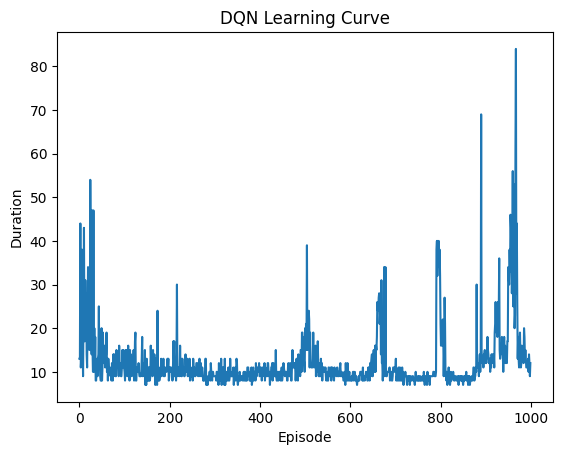

In [16]:
# Plotting the results
plt.plot(rewards)
plt.title('DQN Learning Curve')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.show()

### Closing Environment

In [17]:
env.close()